In [89]:
import pandas as pd  # Load and manipulate dataset (CSV with title/text/label)

import matplotlib.pyplot as plt  # Basic plots (e.g., distributions, results)
import seaborn as sns  # Beautiful statistical visualizations (confusion matrix, countplots)

import spacy  # Advanced NLP: tokenization, lemmatization, NER
from spacy import displacy  # Visualize NER and dependency parses
from spacy import tokenizer  # Fast, accurate tokenizer

import re  # Regex to clean text (remove URLs, punctuation, etc.)

import nltk  # Classic NLP tools
from nltk.tokenize import word_tokenize  # Split text into words
from nltk.stem import PorterStemmer, WordNetLemmatizer  # Stemming & lemmatization
from nltk.corpus import stopwords  # Remove common words (the, a, etc.)
nltk.download('wordnet')
nltk.download('omw-1.4')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Sentiment analysis (fake news often extreme)

import gensim  # Topic modeling (LDA) and embeddings
import gensim.corpora as corpora  # Create dictionary/corpus for gensim
from gensim.models.coherencemodel import CoherenceModel  # Evaluate topic quality
from gensim.models import LsiModel, TfidfModel  # Alternative feature extraction

from sklearn.feature_extraction.text import TfidfVectorizer  # Main feature: TF-IDF vectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Bag-of-words & TF-IDF

from sklearn.model_selection import train_test_split  # Split data into train/test

from sklearn.linear_model import LogisticRegression, SGDClassifier  # Classification models (great for text)

from sklearn.metrics import accuracy_score, classification_report  # Evaluate model performance

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [90]:
# set plot options
plt.rcParams['figure.figsize'] = (12,8)
default_plot_color = '#00bfbf'

In [91]:
data = pd.read_csv('fake_news_data.csv')

In [92]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

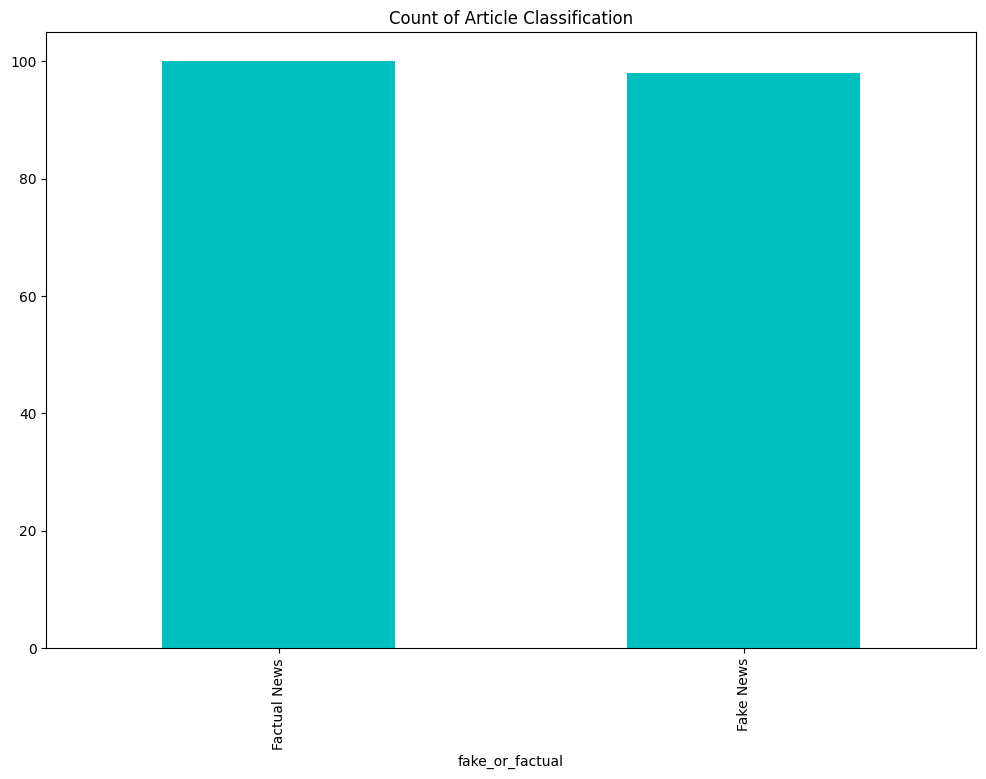

In [94]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title('Count of Article Classification')

### POS TAGGING

In [95]:
nlp = spacy.load('en_core_web_sm')

In [96]:
# Split the dataset into fake and factual news
# so we can compare linguistic patterns (POS tags)
# between the two groups independently.

In [97]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
factual_news = data[data['fake_or_factual'] == 'Factual News']

In [98]:
fake_news.shape

(98, 4)

In [99]:
factual_news.shape

(100, 4)

In [100]:
# Convert fake and factual news text into SpaCy Doc objects.
# Using nlp.pipe() allows efficient batch processing for POS analysis.

In [101]:
#list of SpaCy Docs (Fake)
fake_spacydocs = list(nlp.pipe(fake_news['text']))

#ist of SpaCy Docs (Factual)
fact_spacydocs = list(nlp.pipe(factual_news['text']))

In [102]:
len(fake_spacydocs), len(fact_spacydocs)

(98, 100)

In [103]:
# Extract token-level linguistic features from a SpaCy document.
# This includes the raw token text, part-of-speech tag, and named entity type
# for downstream linguistic analysis.

In [104]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return[(i.text, i.ent_type_, i.pos_) for i in doc]

In [105]:
# Prepare an empty container to store token-level POS and NER information
# extracted from the fake news dataset.

fake_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

In [106]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [107]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [108]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [109]:
fact_tagsdf = []

for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

In [110]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [111]:
fact_tagsdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [112]:
# Count the frequency of each token + POS tag combination of fake dataset
pos_counts_fake = (
    fake_tagsdf
    .groupby(['token', 'pos_tag'])            # Group by token and part-of-speech (POS) tag.
    .size()                                   # Count the number of occurrences of each (token, pos_tag) pair.
    .reset_index(name='count')                # Convert it to a DataFrame, and name the count column 'count'.
    .sort_values(by='count', ascending=False) # Sort in descending order by frequency of appearance.
)

# See the top 10 most popular tokens (combined POS)
pos_counts_fake.head(10)

,token,pos_tag,count
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [113]:
# Count the frequency of each token + POS tag combination of factual dataset
pos_counts_fact = (
    fact_tagsdf
    .groupby(['token', 'pos_tag'])            # Group by token and part-of-speech (POS) tag.
    .size()                                   # Count the number of occurrences of each (token, pos_tag) pair.
    .reset_index(name='count')                # Convert it to a DataFrame, and name the count column 'count'.
    .sort_values(by='count', ascending=False) # Sort in descending order by frequency of appearance.
)

# See the top 10 most popular tokens (combined POS)
pos_counts_fact.head(10)

,token,pos_tag,count
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [114]:
# Aggregate token counts by part-of-speech to understand
# the linguistic structure of fake news articles.
# This helps identify stylistic patterns such as heavy use
# of proper nouns and emotionally charged modifiers.

pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [115]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [116]:
pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][:15]

,token,pos_tag,count
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [117]:
pos_counts_fact[pos_counts_fact.pos_tag == 'NOUN'][:15]

,token,pos_tag,count
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


### Name Entities

In [118]:
top_entities_fake = (
    fake_tagsdf[fake_tagsdf['ner_tag'] != ""]
        .groupby(['token', 'ner_tag'])
        .size()
        .reset_index(name='counts')
        .sort_values(by='counts', ascending=False)
)

top_entities_fake.head()

,token,ner_tag,counts
1730,Trump,PERSON,154
1729,Trump,ORG,152
2129,the,ORG,121
592,Clinton,PERSON,118
718,Donald,PERSON,75


In [119]:
top_entities_fact = (
    fact_tagsdf[fact_tagsdf['ner_tag'] != ""]
        .groupby(['token', 'ner_tag'])
        .size()
        .reset_index(name='counts')
        .sort_values(by='counts', ascending=False)
)
top_entities_fact.head()

,token,ner_tag,counts
1968,the,ORG,159
1633,U.S.,GPE,138
1373,Reuters,ORG,131
1615,Trump,PERSON,125
1614,Trump,ORG,124


In [120]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

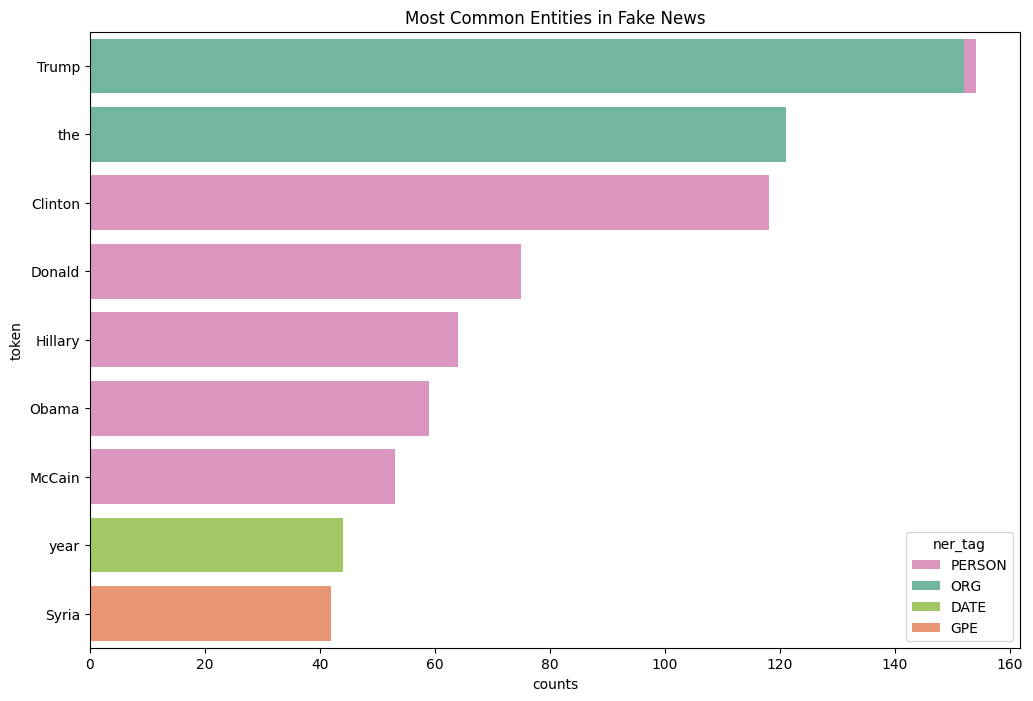

In [121]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

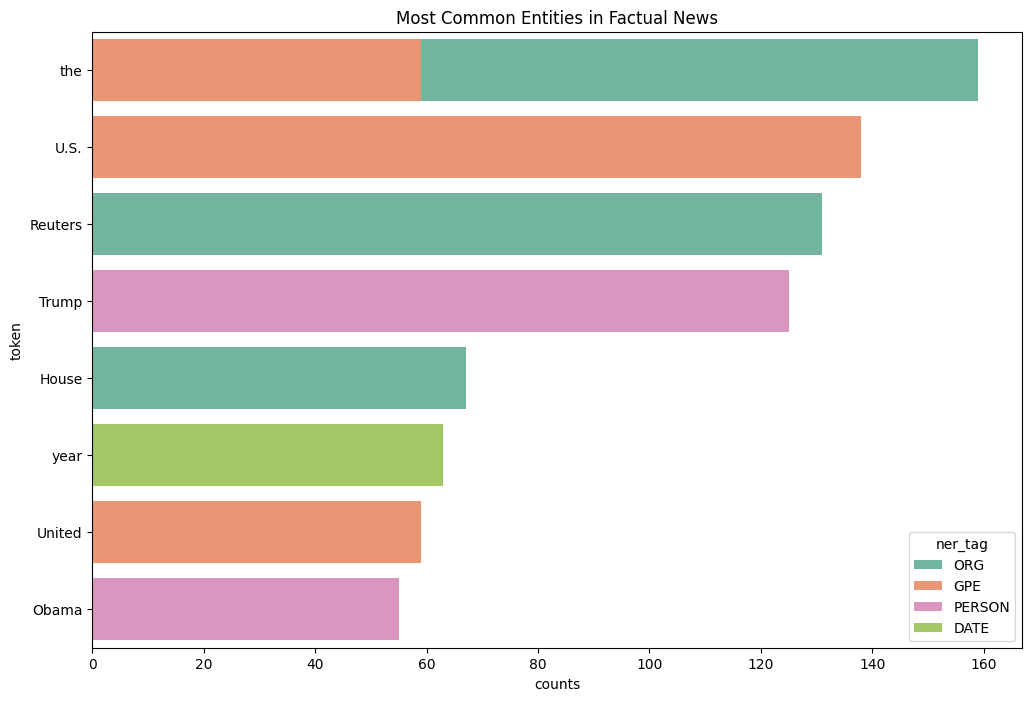

In [122]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Factual News')

### Text Pre-Processing

In [123]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [124]:
data['text_clean'] = data.apply(
    lambda x: re.sub(r"^[^-]*-\s", "", x['text']),
    axis=1
)

In [125]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


In [126]:
data['text_clean'] = data['text_clean'].str.lower()

In [127]:
data['text_clean'] = data['text_clean'].str.replace(r"[^\w\s]", "", regex=True)

In [128]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make up over 50 percent of this country ...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said on monday...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


In [129]:
en_stopwords = stopwords.words('english')
en_stopwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [130]:
data['text_clean'] = data['text_clean'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in en_stopwords])
)

In [131]:
data[['text', 'text_clean']].head(5)

,text,text_clean
0,There are two small problems with your analogy...,two small problems analogy susan jesus muslim ...
1,Buried in Trump s bonkers interview with New Y...,buried trump bonkers interview new york times ...
2,"Women make up over 50 percent of this country,...",women make 50 percent country grossly underrep...
3,WASHINGTON (Reuters) - U.S. Defense Secretary ...,us defense secretary jim mattis said monday ru...
4,BELFAST (Reuters) - Northern Ireland s politic...,northern ireland political parties rapidly run...


In [132]:
data['text_clean'] = data['text_clean'].apply(word_tokenize)

In [133]:
lemmatizer = WordNetLemmatizer()

data["text_clean"] = data["text_clean"].apply(
    lambda tokens: [lemmatizer.lemmatize(token) for token in tokens]
)

In [134]:
data[['text', 'text_clean']].head(5)

,text,text_clean
0,There are two small problems with your analogy...,"[two, small, problem, analogy, susan, jesus, m..."
1,Buried in Trump s bonkers interview with New Y...,"[buried, trump, bonkers, interview, new, york,..."
2,"Women make up over 50 percent of this country,...","[woman, make, 50, percent, country, grossly, u..."
3,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"[u, defense, secretary, jim, mattis, said, mon..."
4,BELFAST (Reuters) - Northern Ireland s politic...,"[northern, ireland, political, party, rapidly,..."


In [135]:
# Flatten tokens
from itertools import chain
tokens_clean = list(chain.from_iterable(data['text_clean']))

In [136]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts())
unigrams[:10]

(said,)          580
(trump,)         580
(u,)             277
(state,)         275
(president,)     259
(would,)         226
(one,)           160
(clinton,)       141
(year,)          139
(republican,)    137
Name: count, dtype: int64

[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

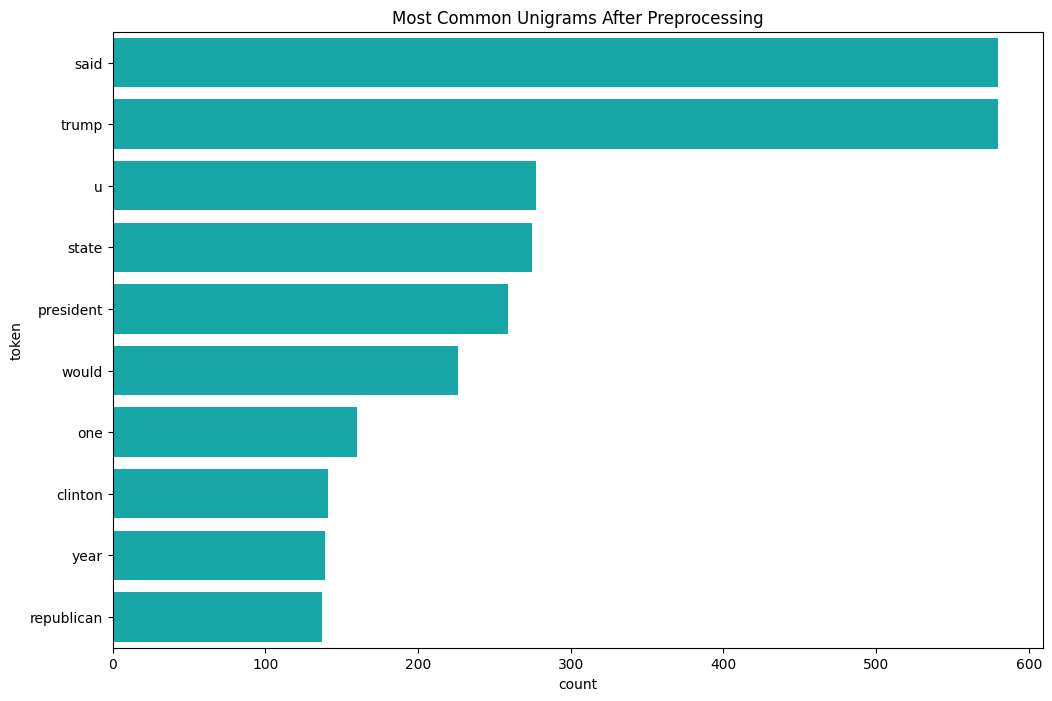

In [137]:
# Convert Series → DataFrame
unigrams_df = unigrams.reset_index()
unigrams_df.columns = ['token_tuple', 'count']

# extract the token from the tuple so we can plot it
unigrams_df['token'] = unigrams_df['token_tuple'].apply(lambda x: x[0]) 

# Plot
sns.barplot(
    x='count',
    y='token',
    data=unigrams_df.head(10),
    orient='h',
    color=default_plot_color
).set(
    title='Most Common Unigrams After Preprocessing'
)

In [138]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts())
bigrams[:10]

(donald, trump)            113
(united, state)             84
(white, house)              74
(president, donald)         47
(hillary, clinton)          39
(new, york)                 33
(supreme, court)            30
(image, via)                29
(official, said)            26
(trump, administration)     26
Name: count, dtype: int64

### Sentiment Analysis

In [139]:
vader_sentiment = SentimentIntensityAnalyzer()

In [140]:
data['vader_sentiment_score'] = data['text'].apply(
    lambda x: vader_sentiment.polarity_scores(x)['compound']
)

In [141]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [142]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative','neutral','positive']

In [143]:
data['vader_sentiment_label'] = pd.cut(
    data['vader_sentiment_score'],
    bins,
    labels=names
)

In [144]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

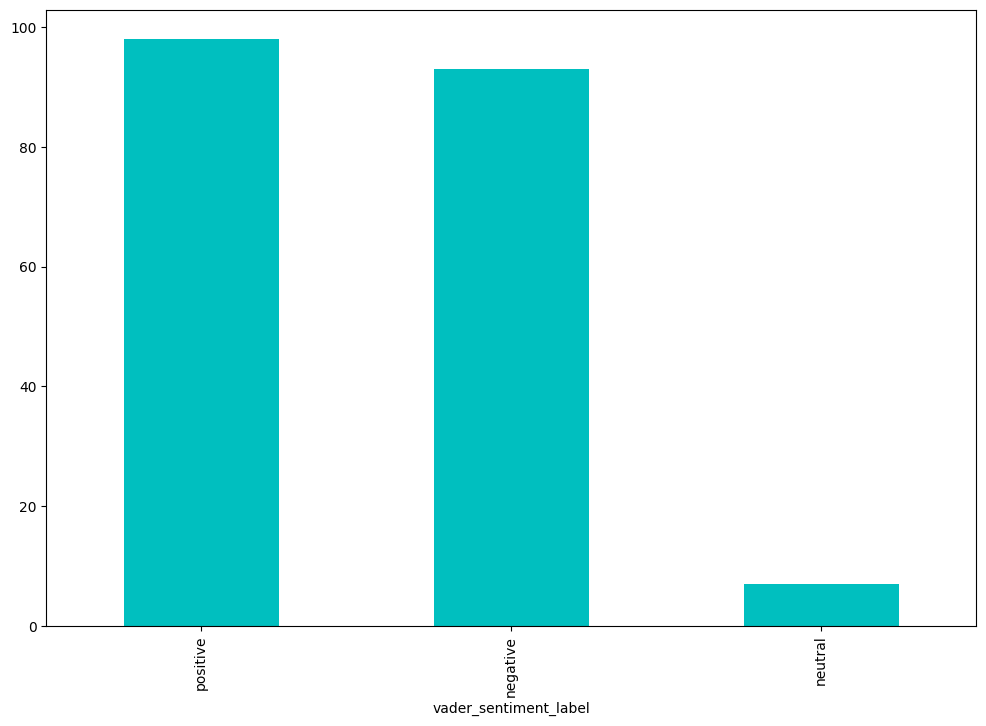

In [145]:
data['vader_sentiment_label'].value_counts().plot.bar(
    color=default_plot_color
)

/tmp/ipykernel_2862/3486754683.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

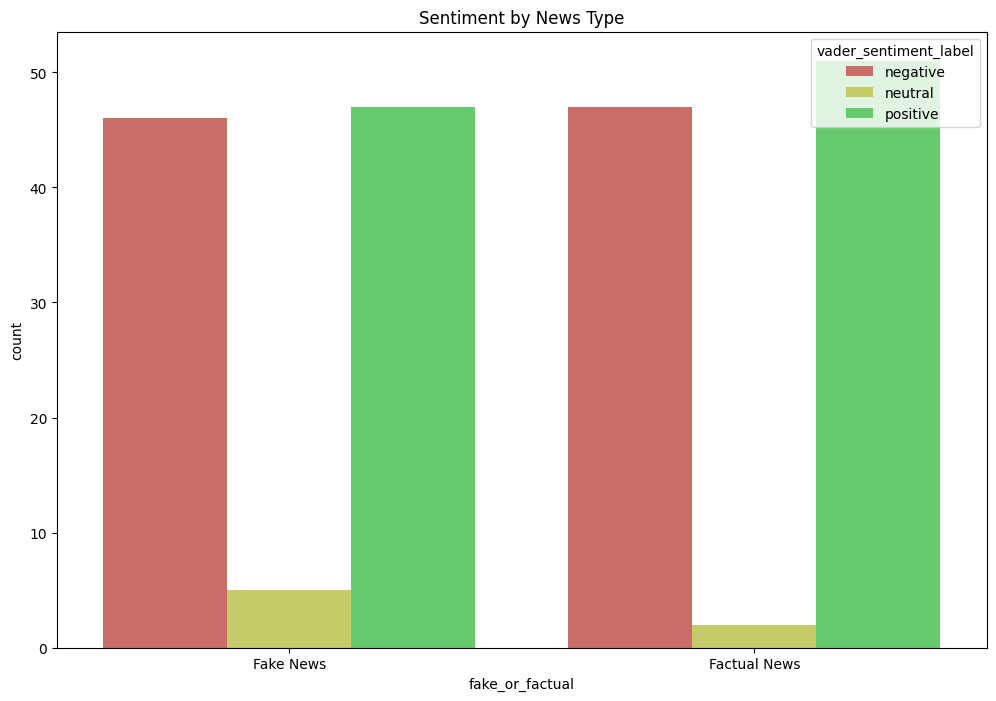

In [146]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette('hls'),
    data = data
).set(title = 'Sentiment by News Type')

### Topic Modeling

In [147]:
fake_news_text = (
    data[data['fake_or_factual'] == "Fake News"]
    ['text_clean']
    .reset_index(drop=True)
)

In [148]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [149]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [150]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(
    doc_term_fake,
    num_topics=num_topics_i,
    id2word=dictionary_fake
)
    model_list.append(model)
    
    coherence_model = CoherenceModel(
    model=model,
    texts=fake_news_text,
    dictionary=dictionary_fake,
    coherence='c_v'
)
    coherence_values.append(coherence_model.get_coherence())

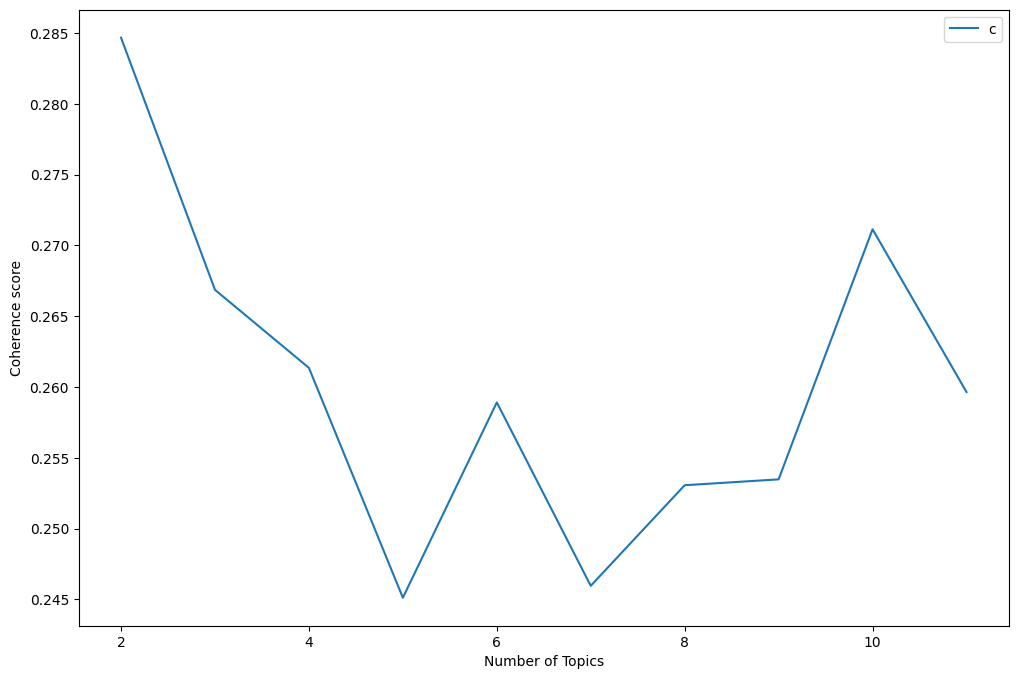

In [151]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [152]:
num_topics_lda = 7
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_lda) 

In [153]:
lda_model.print_topics(num_topics = num_topics_lda, num_words=10)

[(0,
  '0.012*"trump" + 0.005*"president" + 0.004*"u" + 0.004*"year" + 0.003*"one" + 0.003*"obama" + 0.003*"said" + 0.003*"american" + 0.003*"like" + 0.003*"would"'),
 (1,
  '0.016*"trump" + 0.006*"said" + 0.005*"clinton" + 0.004*"president" + 0.004*"state" + 0.004*"would" + 0.004*"people" + 0.004*"donald" + 0.004*"woman" + 0.003*"republican"'),
 (2,
  '0.012*"trump" + 0.005*"state" + 0.005*"said" + 0.005*"president" + 0.004*"clinton" + 0.003*"time" + 0.003*"one" + 0.003*"hillary" + 0.003*"people" + 0.003*"obama"'),
 (3,
  '0.010*"trump" + 0.005*"clinton" + 0.005*"said" + 0.004*"u" + 0.004*"president" + 0.004*"mccain" + 0.004*"one" + 0.004*"would" + 0.003*"state" + 0.003*"even"'),
 (4,
  '0.011*"trump" + 0.006*"clinton" + 0.005*"state" + 0.005*"president" + 0.004*"time" + 0.004*"u" + 0.004*"said" + 0.004*"woman" + 0.003*"republican" + 0.003*"year"'),
 (5,
  '0.008*"trump" + 0.005*"said" + 0.005*"would" + 0.004*"one" + 0.004*"president" + 0.004*"state" + 0.003*"u" + 0.003*"time" + 0.003

In [154]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [155]:
def get_coherence_scores(corpus, dictionary, texts, min_topics, max_topics):
    coherence_values = []
    model_list = []

    for num_topics_i in range(min_topics, max_topics + 1):
        model = LsiModel(
            corpus=corpus,
            num_topics=num_topics_i,
            id2word=dictionary
        )
        model_list.append(model)

        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherence_model.get_coherence())

    # plot results
    plt.plot(range(min_topics, max_topics + 1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.title("LSA Coherence Scores by Number of Topics")
    plt.show()

    return model_list, coherence_values

In [156]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

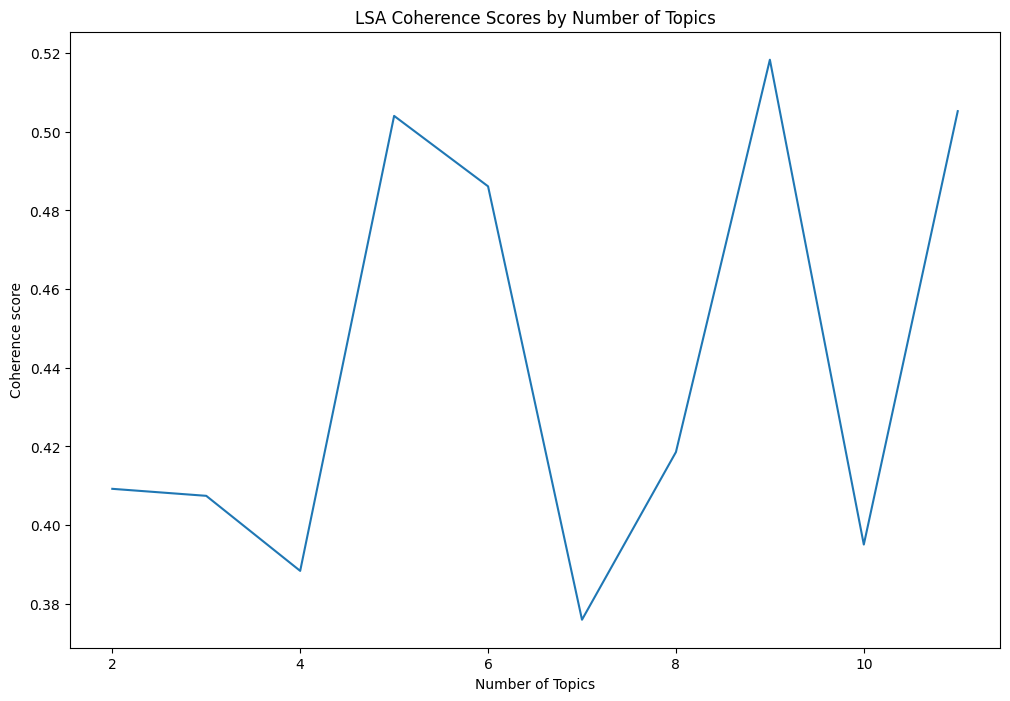

([<gensim.models.lsimodel.LsiModel at 0x776678634e00>,
 [0.4092142198650001,
  0.40743321277072186,
  0.38834887827400866,
  0.5040441971457945,
  0.4861347291880007,
  0.37592870127874944,
  0.41856176299296954,
  0.5183307087305057,
  0.3950438711999671,
  0.5052514448048208])

In [157]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [159]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=7)

In [160]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"animal" + -0.142*"tune" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '0.623*"flynn" + 0.182*"immunity" + 0.122*"nana" + 0.116*"mr" + 0.110*"30" + 0.108*"march" + 0.102*"russian" + 0.100*"source" + -0.095*"school" + 0.092*"adviser"'),
 (3,
  '-0.217*"clinton" + 0.186*"school" + 0.176*"student" + -0.141*"hillary" + 0.121*"county" + 0.121*"flynn" + -0.110*"sander" + -0.098*"debate" + -0.097*"woman" + -0.091*"nominee"'),
 (4,
  '-0.200*"email" + 0.194*"trump" + -0.168*"dnc" + 0.142*"flynn" + -0.126*"clinton" + 0.112*"cruz" + -0.111*"department" + -0.110*"rich" + -0.102*"wikileaks" + -0.099*"sander"'),
 (5,
  '-0.276*"student" + -0.160*"conference" + -0.160*"school" + -0.137*"trump" + 0.125*"mc

### Creating our classification model

In [161]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [164]:
X = data['text_clean'].apply(lambda tokens: ' '.join(tokens))

In [165]:
Y = data['fake_or_factual']

In [166]:
countvec = CountVectorizer()

In [167]:
countvec_fit = countvec.fit_transform(X)

In [170]:
bag_of_words = pd.DataFrame(
    countvec_fit.toarray(),
    columns=countvec.get_feature_names_out()
)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    bag_of_words, 
    Y, 
    test_size=0.3
)

#### Logistic Regression baseline

In [195]:
# Logistic Regression is used as a baseline classifier.
# Despite its simplicity, it often performs exceptionally well
# for high-dimensional sparse text data.

In [178]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [179]:
y_pred_lr = lr.predict(X_test)

In [180]:
accuracy_score(y_pred_lr, y_test)

0.9

In [181]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.91      0.91      0.91        33
   Fake News       0.89      0.89      0.89        27

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



#### SVM comparison

In [189]:
# A Linear SVM (via SGDClassifier) is evaluated for comparison.
# Although powerful, it does not outperform Logistic Regression here,
# reinforcing the importance of starting with simple models.

In [190]:
svm = SGDClassifier().fit(X_train, y_train)

In [191]:
y_pred_svm = svm.predict(X_test)

In [192]:
accuracy_score(y_pred_svm, y_test)

0.8333333333333334

In [193]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.74      0.92      0.82        25
   Fake News       0.93      0.77      0.84        35

    accuracy                           0.83        60
   macro avg       0.84      0.85      0.83        60
weighted avg       0.85      0.83      0.83        60

